In [1]:
# Import Required Libraries
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Freezing VGG Layers   # Why freeze?
- Prevent pretrained weights from changing
- Avoid overfitting
- Faster training

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/archive (7)/Testing",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1311 images belonging to 4 classes.


In [19]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# Get the actual number of classes from the generator
num_classes = train_generator.num_classes
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [20]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.3941 - loss: 2.4507
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.8111 - loss: 0.5209
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8763 - loss: 0.3515
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9188 - loss: 0.2602
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9411 - loss: 0.1889
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9516 - loss: 0.1645
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9739 - loss: 0.1243
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9783 - loss: 0.1036
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9889 - loss: 0.0833
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9847 - loss: 0.0720


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


train_generator.reset()  # Reset generator to start from first batch


y_pred_prob = model.predict(train_generator, steps=len(train_generator)) # Predict probabilities

y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

y_true = train_generator.classes# True labels

# Class names
class_labels = list(train_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.25      0.25      0.25       300
  meningioma       0.24      0.24      0.24       306
     notumor       0.34      0.34      0.34       405
   pituitary       0.21      0.21      0.21       300

    accuracy                           0.27      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.27      0.27      0.27      1311

Confusion Matrix:

[[ 74  75  85  66]
 [ 70  74  88  74]
 [ 81  89 138  97]
 [ 74  69  94  63]]


In [23]:
# Save the entire model
model.save('/content/drive/MyDrive/new_model.h5')

In [24]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('/content/drive/MyDrive/new_model.h5')

In [38]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma','meningioma', 'notumor','pituitary']

def detect_and_display(img_path, model, image_size=224):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


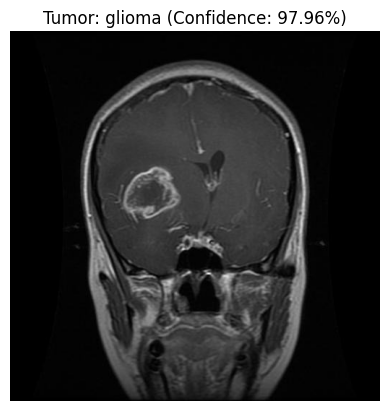

In [39]:
image_path = "/content/drive/MyDrive/archive (7)/Training/glioma/Tr-glTr_0009.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


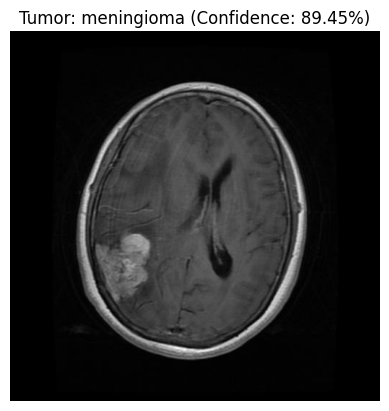

In [40]:
image_path = "/content/drive/MyDrive/archive (7)/Training/meningioma/Tr-meTr_0007.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


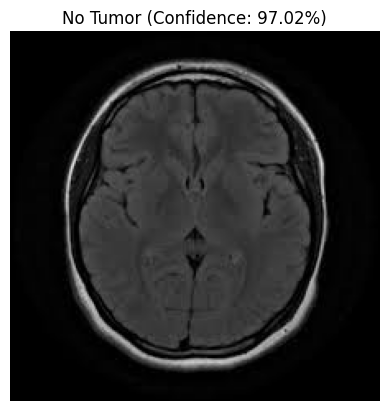

In [41]:
image_path = "/content/drive/MyDrive/archive (7)/Training/notumor/Tr-no_0026.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


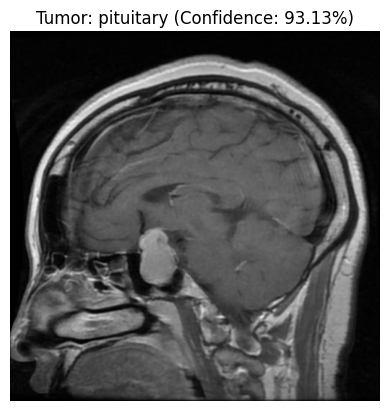

In [42]:
image_path = "/content/drive/MyDrive/archive (7)/Training/pituitary/Tr-pi_0022.jpg"
detect_and_display(image_path, model)